## Data Loading

In [57]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [58]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS =10

In [59]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'rice_leaf_disease_images',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 7926 files belonging to 5 classes.


In [60]:
class_names = dataset.class_names
class_names

['Bacterialblight', 'Blast', 'Brownspot', 'Healthy', 'Tungro']

In [61]:
len(dataset) #186*32=5931

248

In [62]:
# One random batch of images
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[2 3 3 3 0 0 4 0 4 4 1 3 1 0 4 2 4 4 1 2 4 4 2 2 4 1 0 1 4 2 4 0]


(32, 224, 224, 3)
[3 2 4 4 4 1 0 1 2 0 0 4 4 3 3 0 4 3 0 3 4 3 0 0 2 0 4 0 4 0 2 0]


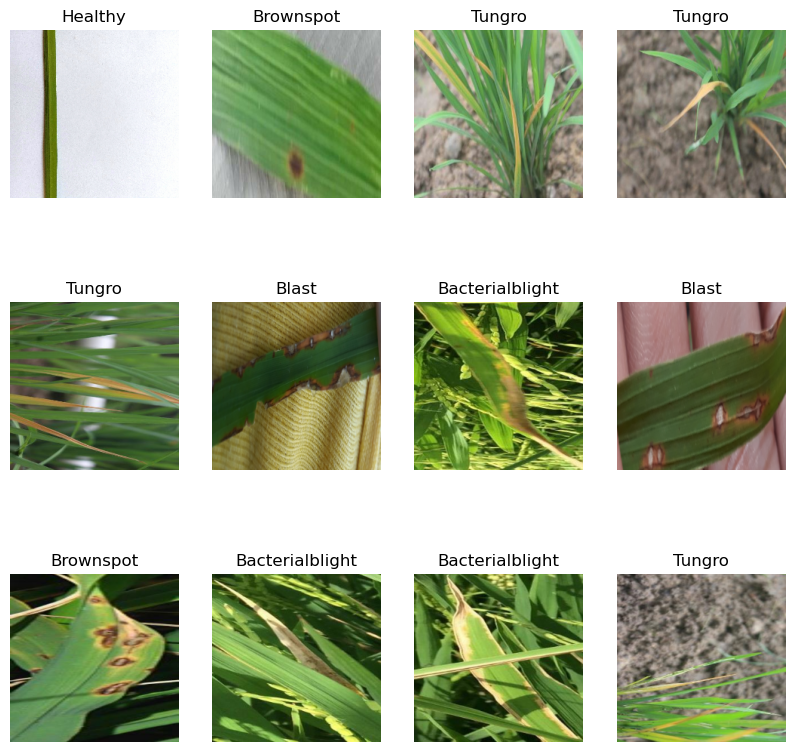

In [63]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12): #showing 12 images out of 32
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [64]:
# (32=batch_size, 256, 256=image_size, 0 to 3=typesofdiseases)
# 0 - Bacterial Blight
# 1 - Blast
# 2 - Brownspot
# 3 - Tungro

In [65]:
# Spitting dataset for training, validation and testing
# 80% for training 10% for validation and 10% for testing
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [66]:
train_ds, val_ds, test_ds =get_dataset_partitions_tf(dataset)

In [67]:
# Catching and prefeching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Preprocessing

In [12]:
# Layer for resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## VGG16

In [14]:
from tensorflow.keras.applications.vgg19 import VGG19

In [15]:
vgg19 = VGG19(input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS),weights='imagenet',include_top=False)

In [16]:
# Don't train existing weights
for layer in vgg19.layers:
    layer.trainable = False

In [17]:
x = tf.keras.layers.Flatten()(vgg19.output)

In [18]:
prediction = tf.keras.layers.Dense(len(class_names),activation='softmax')(x)

In [19]:
model = tf.keras.Model(inputs=vgg19.input, outputs=prediction)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=['accuracy'])

In [22]:
logdir='logs'

In [23]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [24]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[tensorboard_callback]
)

Epoch 1/10
198/198 [==============================] - 3461s 16s/step - loss: 2.1205 - accuracy: 0.8946 - val_loss: 0.8742 - val_accuracy: 0.9492
Epoch 2/10
198/198 [==============================] - 1859s 9s/step - loss: 0.4323 - accuracy: 0.9738 - val_loss: 0.4227 - val_accuracy: 0.9753
Epoch 3/10
198/198 [==============================] - 20341s 103s/step - loss: 0.2485 - accuracy: 0.9832 - val_loss: 0.1618 - val_accuracy: 0.9909
Epoch 4/10
198/198 [==============================] - 1700s 9s/step - loss: 0.2799 - accuracy: 0.9842 - val_loss: 0.2276 - val_accuracy: 0.9857
Epoch 5/10
198/198 [==============================] - 1429s 7s/step - loss: 0.1863 - accuracy: 0.9889 - val_loss: 0.1811 - val_accuracy: 0.9896
Epoch 6/10
198/198 [==============================] - 1483s 7s/step - loss: 0.1109 - accuracy: 0.9945 - val_loss: 0.1456 - val_accuracy: 0.9922
Epoch 7/10
198/198 [==============================] - 1695s 9s/step - loss: 0.0728 - accuracy: 0.9949 - val_loss: 0.1907 - val_accur

In [25]:
scores = model.evaluate(test_ds)
scores

26/26 [==============================] - 337s 10s/step - loss: 0.2643 - accuracy: 0.9880


[0.26430729031562805, 0.9879807829856873]

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

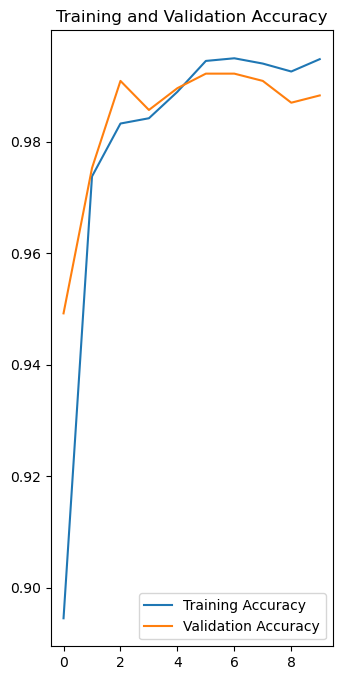

In [27]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    prediction = model.predict(img_array)
    
    prediction_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])),2)
    
    return prediction_class, confidence

1/1 [==============================] - 0s 409ms/step


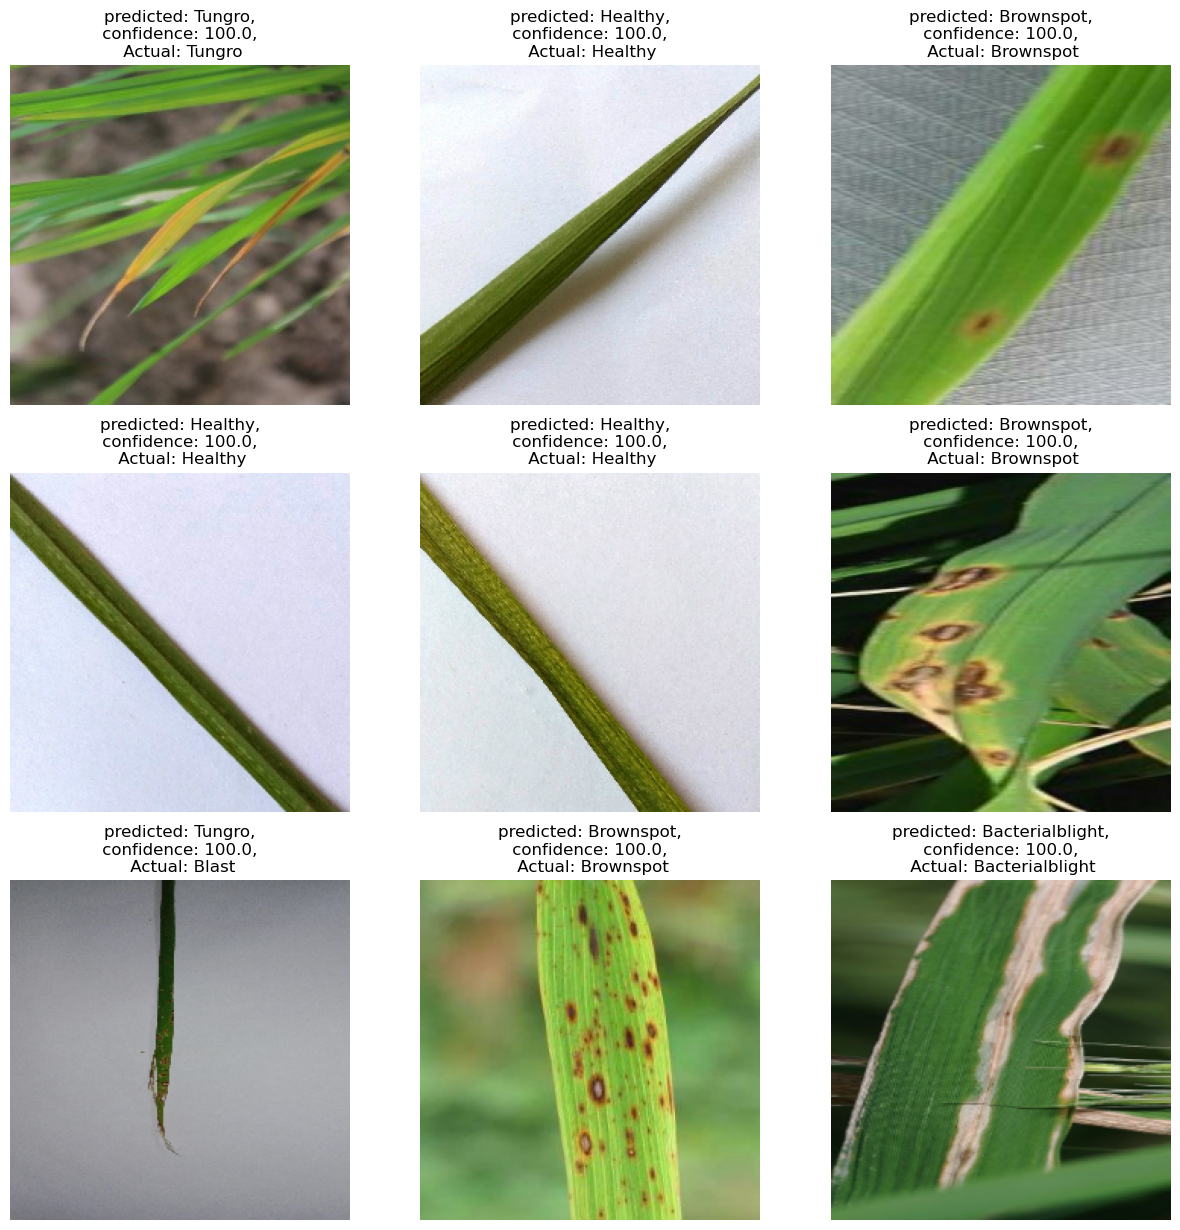

In [29]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'predicted: {predicted_class},\n confidence: {confidence}, \n Actual: {actual_class}')
        plt.axis("off")

In [52]:
# Saving the model
model_version = max([int(i) for i in os.listdir("new_models") + [0]])+1
model.save(f'new_models\{model_version}')

INFO:tensorflow:Assets written to: new_models\3\assets


INFO:tensorflow:Assets written to: new_models\3\assets


In [53]:
new_model = tf.keras.models.load_model('new_models/3')

# Check its architecture
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [54]:
from sklearn.metrics import confusion_matrix , classification_report

26/26 [==============================] - 264s 7s/step


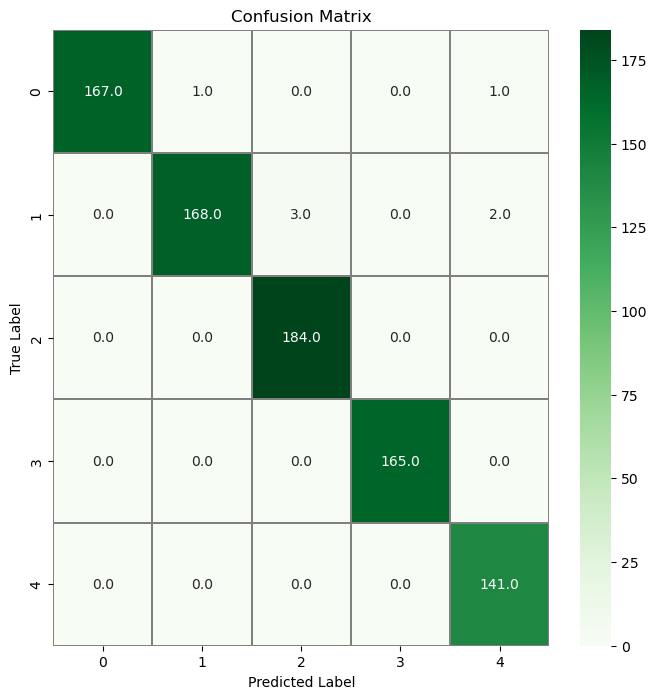

In [68]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = new_model.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = tf.concat([y for x, y in test_ds], axis=0)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [69]:
print(classification_report(Y_true, Y_pred_classes, target_names=class_names))

                 precision    recall  f1-score   support

Bacterialblight       1.00      0.99      0.99       169
          Blast       0.99      0.97      0.98       173
      Brownspot       0.98      1.00      0.99       184
        Healthy       1.00      1.00      1.00       165
         Tungro       0.98      1.00      0.99       141

       accuracy                           0.99       832
      macro avg       0.99      0.99      0.99       832
   weighted avg       0.99      0.99      0.99       832



In [35]:
import numpy as np
import cv2

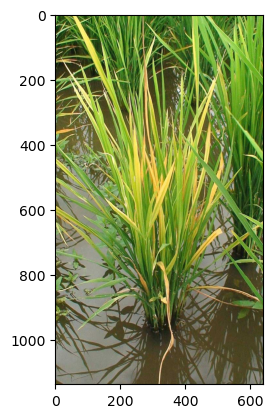

In [75]:
img_path = cv2.imread(os.path.join('Testing Images','t.jfif'))
img_path = cv2.cvtColor(img_path,cv2.COLOR_BGR2RGB)
plt.imshow(img_path)

In [76]:
img = cv2.resize(img_path,(224,224))
img = np.reshape(img,[1,224,224,3])

In [77]:
pred = new_model.predict(img)

1/1 [==============================] - 0s 332ms/step


In [78]:
pred

array([[0., 0., 0., 0., 1.]], dtype=float32)

In [79]:
prediction_class = class_names[np.argmax(pred)]
prediction_class

'Tungro'